<a href="https://colab.research.google.com/github/ssttv/ml-resources/blob/master/fastai_rf_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip3 install fastai==0.7.0

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import feather

In [0]:
set_plot_sizes(12,14,16)

In [0]:
PATH = '/content/drive/generic_datasets/bulldozer/'

In [0]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [0]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [0]:
m = RandomForestRegressor(n_jobs=-1)

In [9]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [0]:
train_cats(df_raw)

In [0]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [0]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
set_rf_samples(50000)


In [17]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20550247641126557, 0.2477412113360695, 0.9117389793088928, 0.8903914361321622, 0.8947823805636419]


In [18]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.44 s, sys: 56 ms, total: 1.49 s
Wall time: 1.5 s


(9.32440460551759, 0.3353114899265859)

In [19]:

def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 93 ms, sys: 141 ms, total: 234 ms
Wall time: 1.59 s


(9.32440460551759, 0.3353114899265859)

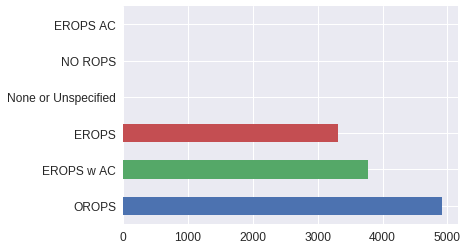

In [20]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [21]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839795,0.271895
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.576396,0.263987
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685991,0.224130


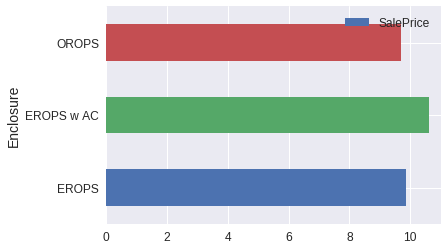

In [22]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

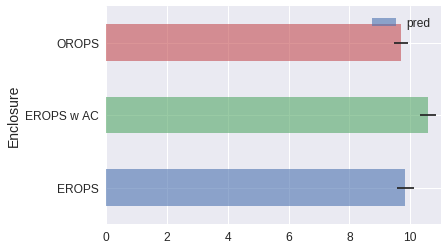

In [23]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));


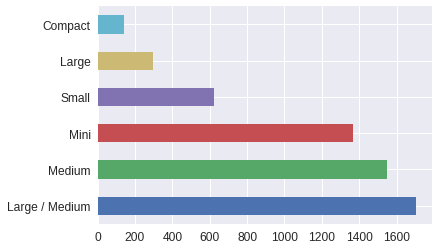

In [24]:
raw_valid.ProductSize.value_counts().plot.barh();


In [25]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.895172,0.368830
Large,10.470589,10.385654,0.356040
Large / Medium,10.691871,10.649506,0.297926
Medium,10.681511,10.625785,0.280467
Mini,9.535147,9.550312,0.250321
Small,10.324448,10.331582,0.292568


In [26]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.037274
Large             0.034282
Small             0.028318
Large / Medium    0.027976
Medium            0.026395
Mini              0.026211
dtype: float64

In [27]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.170003
37,Coupler_System,0.123991
13,ProductSize,0.098808
14,fiProductClassDesc,0.077011
2,ModelID,0.064991
63,saleElapsed,0.050969
10,fiSecondaryDesc,0.045005
39,Hydraulics_Flow,0.041162
38,Grouser_Tracks,0.036051
8,fiModelDesc,0.030418


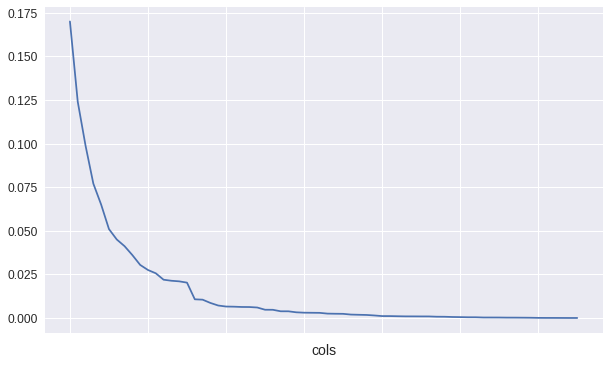

In [28]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);


In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

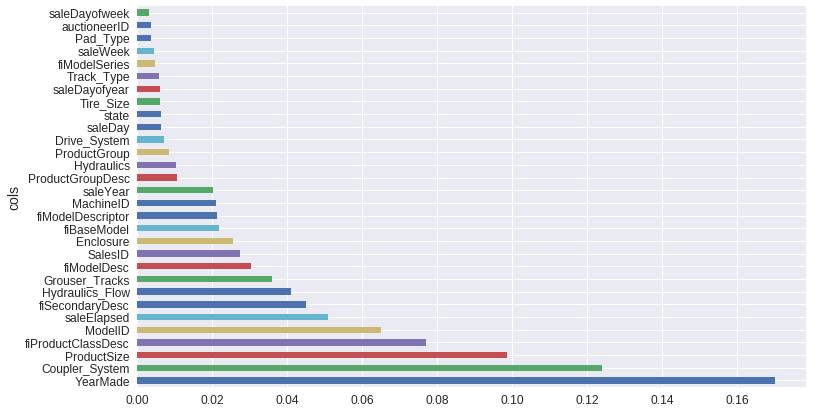

In [30]:
plot_fi(fi[:30])

In [31]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [33]:

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2071079142993822, 0.24530727504322147, 0.9103545573006185, 0.8925345577173516, 0.8940714740001171]


In [34]:

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20700715501606543, 0.245618779430328, 0.9104417622090264, 0.8922614536154555, 0.8941192524920158]


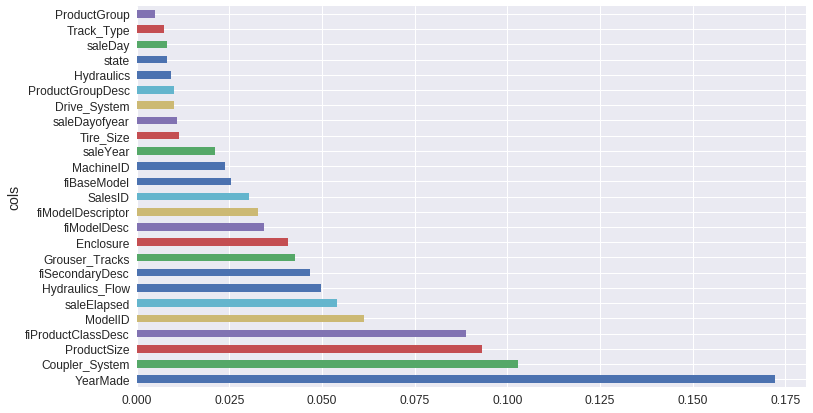

In [35]:

fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [36]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20729599309060895, 0.2549930444101841, 0.9101916657743032, 0.8838806376836958, 0.8924701937248097]
